<a href="https://colab.research.google.com/github/HannaKi/Deep_Learning_in_LangTech_course/blob/master/seq2label_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Label with conv-nets

## Goals of the lecture

1. Understand seq2label problem setting
2. Understanding how 1d-convolution and its practicalities work
3. Acquiring capability to implement seq2label models with conv-nets on keras

## Outline

0. Intro
1. Few words about seq2label, data and its form
2. Detailed look into a simple example model
3. Look into a more complicated model
4. Look into what might be happening here

## Seq2label


### Recap on Bag-Of-Words


#### Input

As was previously discussed, when we are bulding a bag of words - classifier, our input is a set of unordered words and the output is a single label. 

The list of words is given to the model as a feature vector, a single numerical vector. So, to repeat its input is a single vector.

To do this transformation, all tokens need to have a numerical identification. That is, each word is associated with a specific number. In practice this is retrieved from a vocabulary as was shown before.

### Output

Its output is a label. As such it is a function from a vector into a label.

Labels are typically represented as a vector, which has a value for all possible labels, or a single value if the task is binary.

### How Seq2Label differs from this?

The only difference from the bow is the form of the input.

Like in the bow example, the input is a single vector, but instead of representing a set, it represents a sequence. This is achieved simply by adding the token identifiers after each other.

The output is identical.

### A Simple Example


In [3]:
%%script bash

#uncomment this stuff to download data
mkdir -p data
cd data
wget --quiet https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
unzip wiki-news-300d-1M.vec.zip
wget https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/raw/master/data/imdb_train.json
cd ..

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


--2020-04-28 10:50:47--  https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/raw/master/data/imdb_train.json
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TurkuNLP/Deep_Learning_in_LangTech_course/master/data/imdb_train.json [following]
--2020-04-28 10:50:47--  https://raw.githubusercontent.com/TurkuNLP/Deep_Learning_in_LangTech_course/master/data/imdb_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33944099 (32M) [text/plain]
Saving to: ‘imdb_train.json’

     0K .......... .......... .......... .......... ..........  0% 1.70M 19s
    50K .......... .......... .......... ......

In [4]:
#Let's define a simple and short vocabulary
tokens = list(set('it is essential the cat sat on the mat'.split()))
token_ids = {}
for i,t in enumerate(tokens):
    print (i,':',t)
    token_ids[t] = i

0 : mat
1 : cat
2 : essential
3 : the
4 : is
5 : on
6 : sat
7 : it


In [5]:
#Let's define a sentence we want to turn into a vector form

sentence = 'cat sat on the mat'.split()
print(sentence)

['cat', 'sat', 'on', 'the', 'mat']


In [6]:
#Bag of words vector
import numpy as np

#Vector is as long as the vocabulary, initial values are zeros
vector = np.zeros((len(token_ids),))
for token in sentence:
    vector[token_ids[token]] = 1.0
print (vector)

[1. 1. 0. 1. 0. 1. 1. 0.]


In [7]:
#Sequential input vector

vector = [token_ids[t] for t in sentence]
print (vector)

[1, 6, 5, 3, 0]


### Padding of the data

Some deep-learning frameworks, such as keras, require the input to have a preset shape which is the same for all examples. This is not the case with all frameworks, but its good to cover. If for nothing else, for the sake of this tutorial.

Since these input sequences are not the same length, we need to make them so. This is accomplished by padding, which in practice means adding zeros to the input vectors to make them uniform in size

Note! Zero should not be ine token IDs!


In [8]:
#Padding can easily be achieved with keras in-built functions
from keras.preprocessing.sequence import pad_sequences

pad_sequences(np.array([vector]), maxlen=20, padding='post')

Using TensorFlow backend.


array([[1, 6, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

### Super short recap on embedding layers

Most often these sequences of numbers are used to load embeddings, which are used as the input of the next stage of the network. An embedding layer could be imagined as a dictionary; in go indexes, out comes representative embeddings.

What happens inside an embedding layer can be demonstrated with numpy:

In [9]:
import numpy as np
embedding_size = 4
#Let's just make a random matrix to act as our demonstration embedding matrix
embedding_matrix = np.random.rand(len(token_ids),embedding_size)

print ('from:', vector)
print ('into:')
print (embedding_matrix[vector])
print ('and the matrix has a shape:', embedding_matrix[vector].shape)



from: [1, 6, 5, 3, 0]
into:
[[0.7737251  0.88603776 0.28706364 0.76989617]
 [0.36507212 0.19820014 0.74716038 0.06779487]
 [0.74796081 0.05676394 0.30916191 0.83567972]
 [0.02013309 0.30187618 0.89700099 0.61359054]
 [0.34120537 0.6408004  0.92079974 0.79889234]]
and the matrix has a shape: (5, 4)


## Convolution recap

### What's good about convolution?

Convolutional networks are fast. They are fast because they are easily parallelizable. That is because no part of the convolution output depends on another one of the outputs. If that was the case, as it is in recurrent neural networks we couldn't make predictions before other parts of the layer have finished calculating.

### 1-dimensional convolution

During he earlier lecture and also to a large degree on the internet, image classification is used to demonstrate conv-nets. That is very understandable, for that is the area in which these networks traditionally shine and also because the convolution operation is a traditional tool for image processing.

An image is a two dimensional input. It has height and it has width. A sequence of words has only one dimension. That is, you can traverse it forwards and backwards, but there is no traversing it "up" or "down" nor is there "toward" and "from" etc. It just is a one-dimensional sequence of tokens.

Because of this, the convolution operation applied to text is usally one dimensional, instead of two dimensional convolution often applied to images.

The relevant variables in the operation are:

1. Filter size, in effect how many conv operations are applied to the input
2. Kernel size, in effect how wide the applied conv operations are
3. Stride length
4. Padding

#### Input / Output

This operation takes as its input 2-d matrices (when we discount the batch_size). The matrix is in the shape of (steps, input_dim)

The operation returns similarly a 2-d matrix. The size of the output matrix is (new_steps, filters). In this shape filters correspond to the amount of filters used. The new step count is a little bit trickier. It depends on stride length, kernel size and used padding style. 
https://keras.io/layers/convolutional/#conv1d


### Illustration



```
# This is formatted as code
```

![title](https://github.com/HannaKi/Deep_Learning_in_LangTech_course/blob/master/Untitled.png?raw=1)

## 1-dimensional convolution and text

Since the convolutional network bases its activations on a window of certain length, it is reacting to snippets of text the size of the convolution window. For example a conv-net with a window size of three, is capable of reacting to trigrams etc. In this sense convolutional text classifiers remind us of bag-of-ngram classifiers.

In [10]:
import json
inf = open('data/imdb_train.json','rt')
ebin = json.load(inf)
inf.close()


print (ebin[0])

{'class': 'pos', 'text': "With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.  Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.  The actual feature film bit when it finall

### Pooling

The pooling operation is used for dimensionality reduction of the input. The type of pooling discussed in this lecture is max-pooling, but other variants exist. In the context of this lecture we will be using global pooling, similarly variants exist.

Global, 1 dimensional, max pooling operation takes as its input a 2-d matrix and returns a vector. 

This operation is best explained with an illustration.

### Illustration


In [11]:
#We can illustrate global max pooling with numpy
embeddings = embedding_matrix[vector]
print ('we start with:')
print (embeddings)
print ()
print ('after max pooling:')
print (np.max(embeddings, axis=0))

we start with:
[[0.7737251  0.88603776 0.28706364 0.76989617]
 [0.36507212 0.19820014 0.74716038 0.06779487]
 [0.74796081 0.05676394 0.30916191 0.83567972]
 [0.02013309 0.30187618 0.89700099 0.61359054]
 [0.34120537 0.6408004  0.92079974 0.79889234]]

after max pooling:
[0.7737251  0.88603776 0.92079974 0.83567972]


### ReLU

Rectified linear unit. An activation used often with conv-nets. As an activation it doesn't care about input size. Input and output are always of similar shape. Simply returns the value if it is >0 and 0 otherwise.



## The simple model

To start of this lecture, let us look into an example convnet-text classifier included in keras examples: https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py

It uses the IMDB-dataset already we are already familiar with and contains a single convolution layer. It's performance is said to be 0.89, which is somewhat disappointingly less than the bag-of-words example earlier.

In addition to demonstrating a convolutional text classifier, the example nicely illuminates what typical deep-learning code looks like.

For purposes of simplification I've yet very slightly simplified the code.


In [12]:
import json
import random
from sklearn.preprocessing import LabelEncoder

with open("data/imdb_train.json") as f:
    data=json.load(f)
# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
label_encoder=LabelEncoder() #Turns class labels into integers
class_numbers=label_encoder.fit_transform(labels)

max_features = 5000
#Let's make the sequences
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts) 
sequences = tokenizer.texts_to_sequences(texts)
#Let's pad this
from keras.preprocessing.sequence import pad_sequences
max_len = 400
padded_sequences = pad_sequences(sequences, maxlen=400, padding='post')

#And let's have a look!
print ('sequence')
print (sequences[0])
print ('padded sequence')
print(padded_sequences[0])

#And then cut out a development set out of the data for us to see how well we do
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences,
                                                    class_numbers, test_size=0.2, random_state=42)


sequence
[15, 28, 10, 534, 166, 176, 29, 1, 557, 15, 203, 641, 2614, 5, 23, 224, 145, 1, 1027, 658, 129, 2, 46, 292, 1, 2, 292, 170, 275, 9, 39, 177, 5, 75, 3, 809, 2615, 79, 10, 228, 33, 9, 193, 12, 62, 642, 7, 1, 4251, 39, 5, 275, 93, 52, 57, 326, 722, 25, 6, 2511, 38, 1350, 6, 169, 169, 787, 18, 59, 9, 373, 166, 5, 63, 29, 1, 433, 50, 8, 12, 1815, 621, 45, 4, 8, 43, 1298, 3431, 40, 543, 945, 1, 3512, 2, 78, 1, 573, 745, 4, 1663, 22, 74, 2005, 1155, 17, 4, 260, 10, 6, 28, 40, 484, 1877, 34, 890, 21, 2587, 36, 7, 549, 91, 21, 22, 166, 5, 779, 10, 2, 165, 8, 353, 45, 199, 679, 31, 14, 5, 1, 227, 4, 10, 16, 17, 2, 87, 4, 23, 447, 58, 131, 11, 25, 89, 8, 14, 1, 447, 59, 44, 279, 6, 62, 323, 4, 86, 1, 775, 787, 18, 223, 50, 8, 413, 513, 6, 60, 19, 14, 887, 230, 38, 34, 1, 3536, 1669, 716, 2, 910, 6, 1074, 13, 3, 28, 971, 1388, 1630, 134, 25, 489, 347, 34, 74, 6, 720, 68, 84, 23, 2453, 910, 105, 11, 25, 469, 80, 5, 120, 8, 6, 25, 33, 6, 1663, 519, 34, 9, 275, 25, 39, 4137, 224, 771, 4, 642

### Simple model

In [13]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Input
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

from sklearn.preprocessing import OneHotEncoder

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 100
filters = 150
kernel_size = 3
epochs = 5

print('Loading data...')
#(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print (x_train.shape)

#Since we are using output the size of 2, we will have to do one-hot encoding
#x_test = to_categorical(x_test)
#y_test = to_categorical(y_test)


print('Pad sequences (samples x time)')
#xx_train = sequence.pad_sequences(x_train, maxlen=maxlen)
#xx_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

onehot_encoder = OneHotEncoder(sparse=False)
oh_y_test = onehot_encoder.fit_transform(y_test.reshape(-1, 1))
oh_y_train = onehot_encoder.transform(y_train.reshape(-1, 1))



print('Build model...')

#Let's define the inputs
x = Input(shape=(maxlen,))

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions

embedding_layer = Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen)

embeddings = embedding_layer(x)

conv_layer = Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1)
conv_result = conv_layer(embeddings)
pooled = (GlobalMaxPooling1D())(conv_result) 

# We add a vanilla hidden layer:
out = Dense(2, activation='softmax')(pooled)

model = Model(x, out)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.fit(x_train, oh_y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, oh_y_test))


Loading data...
20000 train sequences
5000 test sequences
(20000, 400)
Pad sequences (samples x time)
x_train shape: (20000, 400)
x_test shape: (5000, 400)
Build model...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 65s 3ms/step - loss: 0.4027 - accuracy: 0.8098 - val_loss: 0.2856 - val_accuracy: 0.8826
Epoch 2/5
20000/20000 [==============================] - 64s 3ms/step - loss: 0.2125 - accuracy: 0.9170 - val_loss: 0.2664 - val_accuracy: 0.8940
Epoch 3/5
20000/20000 [==============================] - 64s 3ms/step - loss: 0.1137 - accuracy: 0.9627 - val_loss: 0.2720 - val_accuracy: 0.8930
Epoch 4/5
20000/20000 [==============================] - 64s 3ms/step - loss: 0.0482 - accuracy: 0.9895 - val_loss: 0.3003 - val_accuracy: 0.8928
Epoch 5/5
20000/20000 [==============================] - 66s 3ms/step - loss: 0.0145 - accuracy: 0.9989 - val_loss: 0.3345 - val_accuracy: 0.8934


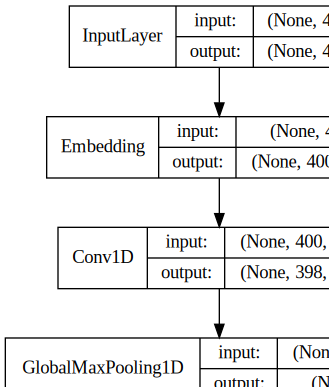

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True,show_layer_names=False).create(prog='dot', format='svg'))
#model_to_dot(model,show_shapes=True,show_layer_names=False)

## What if we were to load pre-trained embeddings?

In [0]:
vocab = tokenizer.word_index

In [19]:
#vocab

{'chitre': 70850,
 'moviewise': 58717,
 'looonnnggg': 80846,
 'salomé': 80275,
 'caricaturish': 53075,
 "'shower'": 66431,}

{"'shower'": 66431,
 'caricaturish': 53075,
 'chitre': 70850,
 'looonnnggg': 80846,
 'moviewise': 58717,
 'salomé': 80275}

In [15]:
##Let's load our embeddings

from gensim.models import KeyedVectors
vector_model=KeyedVectors.load_word2vec_format("data/wiki-news-300d-1M.vec", binary=False, limit=1000000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#...and let's normalize
vector_model.init_sims(replace=True)

In [21]:
#let's create an embedding matrix

import numpy as np

embedding_matrix = np.zeros((max_features, 300))
countr = 0
for token, idx in vocab.items():
    
    if idx < max_features:
        if token in vector_model:
            embedding_matrix[idx] = vector_model[token]
            countr += 1
print (countr)

4893


In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 300
filters = 150
kernel_size = 3
hidden_dims = 250
epochs = 5

print('Loading data...')
#(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
x = Input(shape=(maxlen,))

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions

embedding_layer = Embedding(max_features,
                    embedding_dims,
                    weights = [embedding_matrix],
                    input_length=maxlen)

embeddings = embedding_layer(x)

conv_layer = Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1)
conv_result = conv_layer(embeddings)
pooled = (GlobalMaxPooling1D())(conv_result) 

# We add a vanilla hidden layer:
out = Dense(2, activation='softmax')(pooled)

model = Model(x, out)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.fit(x_train, oh_y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, oh_y_test))


## Yay! It got a little better!

## Good reading:

https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8
http://setosa.io/ev/image-kernels/